# MODEL SELECTION :
- unsupervised learning : LDA
- supervised learning :
- model selection based on topic and mesure coherence

# Unsupervised approach
## Implementing LDA with gensim
LDA  : Latent Ditrichlet Allocation is a supervised method to be used at first during the exploratory work for a better text structure understanding. The model is probabilistic and works over words present in text underlying different topic and it's probability of apparition.

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

UTF-8


In [2]:

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pandas as pd
import numpy as np
import pickle
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 100.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [3]:
!pip install bertopic
!pip install -U sentence-transformers
!pip install --upgrade ipykernel

from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.23.2 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.


/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
sto_token_series_clean = np.load("/content/drive/MyDrive/OpenClassroom/token_series_clean.npy",allow_pickle=True)

In [7]:
sto_corpus = np.load("/content/drive/MyDrive/OpenClassroom/corpus.npy",allow_pickle=True)
sto_titles = np.load("/content/drive/MyDrive/OpenClassroom/titles.npy",allow_pickle=True)
sto_corpus_tags = np.load("/content/drive/MyDrive/OpenClassroom/corpus_tags.npy",allow_pickle=True)

In [8]:
from collections.abc import Iterable
# Check sto_corpus only contains strings :
if isinstance(sto_corpus, Iterable) and not isinstance(sto_corpus, str):
    for doc in sto_corpus :
        if not all([ isinstance(word,str) for word in doc]):
          print(doc)
    # raise TypeError("Make sure that the iterable only contains strings.")


### Take sample for further computation

In [9]:
print(sto_corpus.shape)
print(sto_corpus_tags.shape)
print(sto_titles.shape)

(35881,)
(35881,)
(35881,)


In [10]:
# only take sample for further computation
NB_DOCS = 2000
s_corpus_core = sto_corpus[:NB_DOCS]
s_tags   = sto_corpus_tags[:NB_DOCS]
s_titles = sto_titles[:NB_DOCS]


Let's concatenate title and corpus of each document for unsupervised learning.

In [11]:
s_corpus = [ np.append(s_titles[i] ,s_corpus_core[i]) for i in range(NB_DOCS)]

In [12]:
print(s_titles[0])
print(s_corpus[0])

['splint', 'ignore', 'declare', 'variable']
['splint' 'ignore' 'declare' 'variable' 'splint' 'ignore' 'declare'
 'variable' 'school' 'tell' 'declare' 'variable' 'right' 'beginning'
 'every' 'since' 'person' 'declare' 'thing' 'close' 'good' 'right' 'take'
 'simple' 'stdio.h' 'printf' 'Hello' 'splint' 'test\\n' 'printf' 'splint'
 'compiler' 'move' 'round' 'declaration' 'loop' 'turn' 'check' 'keep'
 'check' 'good' 'Thanks' 'Johan' 'Note' 'already' 'warning' 'defence'
 'valgrind' 'thinking' 'adding' 'splint' 'thing' 'control' 'stupidity'
 'check' 'annoying' 'warning' 'Note' 'potential' 'portability' 'problem'
 'come' 'behaviour' 'feel' 'increase' 'readability' 'needing' 'jump'
 'search' 'declaration' 'valuable' 'discus' 'another' 'Update' 'little'
 'information' 'called' 'main.c' 'Platform' 'Ubuntu' '8.04' 'gvim'
 'editor' 'splint' 'splint' '+gnuextensions' 'main.c' 'Splint' '3.1.1'
 '2006' 'Command' 'Line' 'Setting' '+gnuextensions' 'redundant' 'current'
 'main.c:8:8' 'Parse' 'Error' 'par

## Topic modeling
Let's search for theme in text collection
# id too word dictionary

gensim is a NLP python package and unables the bag-of-words vector representation. Each document is a ligne and in each lign the id of the word appering and it's frequency in the document.

In [13]:
id2word = corpora.Dictionary(s_corpus)

In [105]:

# Term Document Frequency
corpus = [ id2word.doc2bow(text) for text in s_corpus]

In [15]:
print(s_corpus[0])

['splint' 'ignore' 'declare' 'variable' 'splint' 'ignore' 'declare'
 'variable' 'school' 'tell' 'declare' 'variable' 'right' 'beginning'
 'every' 'since' 'person' 'declare' 'thing' 'close' 'good' 'right' 'take'
 'simple' 'stdio.h' 'printf' 'Hello' 'splint' 'test\\n' 'printf' 'splint'
 'compiler' 'move' 'round' 'declaration' 'loop' 'turn' 'check' 'keep'
 'check' 'good' 'Thanks' 'Johan' 'Note' 'already' 'warning' 'defence'
 'valgrind' 'thinking' 'adding' 'splint' 'thing' 'control' 'stupidity'
 'check' 'annoying' 'warning' 'Note' 'potential' 'portability' 'problem'
 'come' 'behaviour' 'feel' 'increase' 'readability' 'needing' 'jump'
 'search' 'declaration' 'valuable' 'discus' 'another' 'Update' 'little'
 'information' 'called' 'main.c' 'Platform' 'Ubuntu' '8.04' 'gvim'
 'editor' 'splint' 'splint' '+gnuextensions' 'main.c' 'Splint' '3.1.1'
 '2006' 'Command' 'Line' 'Setting' '+gnuextensions' 'redundant' 'current'
 'main.c:8:8' 'Parse' 'Error' 'parse' 'error' 'splint' 'parseerrors'
 'open' '

In [16]:
print(len(corpus))
print(len(corpus[0]))
print(len(corpus[1]))
print(corpus[0][:10])

2000
86
101
[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 2)]


In [17]:
# train the model
tfidf = gensim.models.TfidfModel(corpus)

In [18]:
tfidf_corpus = tfidf[corpus]

In [19]:
print(len(tfidf_corpus))
print(len(tfidf_corpus[0]))
print(len(tfidf_corpus[1]))
print(tfidf_corpus[0][:10])

2000
86
101
[(0, 0.1705762139489395), (1, 0.08528810697446974), (2, 0.06518315574039643), (3, 0.08528810697446974), (4, 0.05010539445718436), (5, 0.06313736439885992), (6, 0.04712399584785961), (7, 0.08528810697446974), (8, 0.052249184560765334), (9, 0.06550182019292924)]


### Memory reprsentation : Compressed Sparse Row (csr) matrix
The issue with tf-idf matrix representation (one line per document, one column per copus's word)is that it's almost an empty matrix (most of elements are null). We don't want to store that in memory. To eleviate this issue we represent our matrix with the sparse matrix format.
Sparse matrix represention allows to store only non-zero elements.
- data : list of all non-zeros values of the matrix
- indices : colums index of each element
- indptr : is the start and stop ptr of each row in the sparse matrix, the row 0 is data[ indptr[0], indptr[1] ], therefore it contains the number of row + 1 elements. (when start = next stop only one value is saved )

In [20]:
from scipy.sparse import csr_matrix

def tfidf_to_xsparse(tfidf_in, nb_lines, nb_cols)  :
  """Convert the TF-IDF corpus into a sparse matrix"""
  rows, cols, data = [], [], []
  for i, doc in enumerate(tfidf_in):
      for j, value in doc:
          rows.append(i)
          cols.append(j)
          data.append(value)
  return csr_matrix((data, (rows, cols)), shape=(nb_lines, nb_cols))

X_sparse = tfidf_to_xsparse(tfidf_corpus, len(tfidf_corpus), len(id2word) )


In [21]:
def xspare_to_tfidf(xsparse, dictionnary) :
  corpus_bag_of_words =  []
  feature_names = list(dictionnary.token2id.keys())
  for  idx, v in zip(xsparse.indices, xsparse.data) :
    print(idx , v)
    corpus_bag_of_words.append((idx , v))
  return corpus_bag_of_words

In [22]:
X_sparse.shape


(2000, 48917)

The sparse data representation allows to not store 0 if the word does not exist in the corpus but it still represent one line per document and the frequency of apparition of a unique per columns.

## LSA

SVD (Sigular value decomposition) is a dimension reduction technique based on eigenvectors decoposition and works better on sparse data. In the difference of PCA that uses dimension reduction on the covariance matrix (symetric matrix, the bases vectors are orthogonal and can be normalized to be orhonormal), SVD works on the data matrix. If term word count or TF-IDF is given as input it corresponds to LSA : latent semantic analysis


In [23]:

# Perform Truncated SVD (similar to PCA) on the sparse matrix
svd = TruncatedSVD(n_components=1700, n_iter=7, random_state=33)
svd.fit(X_sparse)
X_svd = svd.transform(X_sparse)


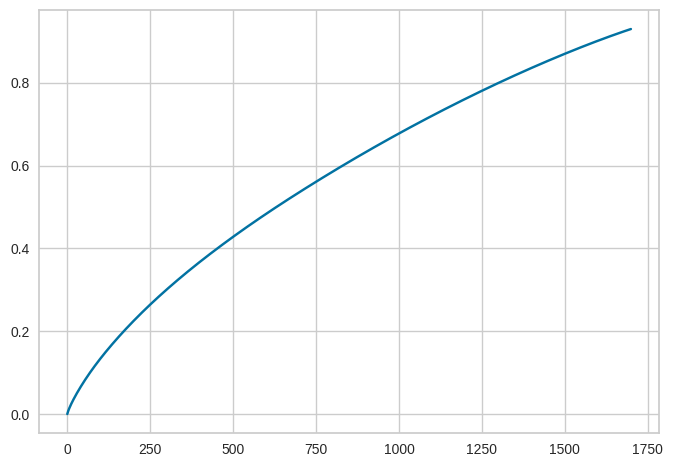

In [24]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

In [25]:
print(svd.explained_variance_ratio_[:1100].sum())
NB_COMPOSANTES = 1100
print(NB_COMPOSANTES/ X_sparse.shape[1] *100)

0.7196093566939958
2.2487069934787494


Here we select 1100 principal components, so we diminish the size of the corpus token representation from 48388 to 1100 so 2% of the orgininal data amount.

In [26]:
def data_preparation(text_copus,svd, v=False) :
  """ bag-of-words to lsa coordinates"""
  if v :
    print("From bag-of-words to lsa coordinates example : ")
    print(f"The document is represented by {len(text_copus[0])} words" )
    print("The first word is : ",text_copus[0][0])
  # Term Document Frequency
  text_corpus_encoded = [ id2word.doc2bow(word) for word in text_copus]
  if v :
    print("First word encoded: ",text_corpus_encoded[0][0])
  # tf_idf
  tf_idf = tfidf[text_corpus_encoded]
  if v :
    print("tf_idf.shape : " , len(tf_idf[0]))
    print("First word tf-idf representation: ",tf_idf[0][0])
  # sparse representation
  sparse_tfidf =  tfidf_to_xsparse(tf_idf, len(tfidf_corpus), len(id2word))
  # PCA
  lsa_coordinates = svd.transform(sparse_tfidf)
  if v :
    print("lsa_coordinates.shape : " , lsa_coordinates.shape)
    print("First word lsa coordinates: ", lsa_coordinates[0][0])
  return lsa_coordinates

In [27]:
lsa_coordinates_example = data_preparation([s_corpus[0]], svd, v=True)

From bag-of-words to lsa coordinates example : 
The document is represented by 119 words
The first word is :  splint
First word encoded:  (0, 2)
tf_idf.shape :  86
First word tf-idf representation:  (0, 0.1705762139489395)
lsa_coordinates.shape :  (2000, 1700)
First word lsa coordinates:  0.09233684759854272


We want to be able to interpret the lsa coordinates and further algorithms output in term of semantic. To do that we need to be able from lsa coordinates to retrieve which word there correspond to. Actually the cannot be done with truncatedSVD , as it applies a truncation and the function inverse_transform is not the inverse of the function transform. As we cannot know the number of words present as input, we will only generate to 10 maximum weight and convert there idexes into words from the dictionnary.

In [28]:
def data_decoding(lsa_coordinates, svd, dic, nb_docs, v=False):
  """ lsa coordinates to most representative 10 words """
  corpus_representation = []
  tfidf = svd.inverse_transform(lsa_coordinates)[:nb_docs]
  if v :
    print("tfdif matrix shape : ", tfidf.shape)
    print("tfidf values", tfidf)
  for text_idx in range(nb_docs):
    idx = tfidf[text_idx].argsort()[::-1][:10]
    if v :
      print("idexes of the most predominqnts 10 words :  ", idx)
    feature_names = list(id2word.token2id.keys())
    corpus_representation.append( [ str(feature_names[i]) for i in idx] )
  if v :
    print("Predominamts 10 words of the lsa representation :")
    print(corpus_representation)
  return corpus_representation



In [29]:
output = data_decoding(lsa_coordinates_example, svd, id2word, 1, v=True)

tfdif matrix shape :  (1, 48917)
tfidf values [[1.66920938e-01 8.34604688e-02 6.42092514e-02 ... 3.31273396e-05
  3.31273396e-05 3.31273396e-05]]
idexes of the most predominqnts 10 words :   [71 32 48  0 85 64 41 53 25 30]
Predominamts 10 words of the lsa representation :
[['splint', 'declare', 'main.c', '+gnuextensions', 'warning', 'redundant', 'ignore', 'parse', 'check', 'current']]


let's check if words were part of the input bag-of-words

In [30]:
np.all(np.isin(output, s_corpus[0]) )

True

Now let's view the new space support vectors, on which words (which were our axes in inputs) are mainly supported bu the nex pricipal components base. Let's compute coherence score on this topics.

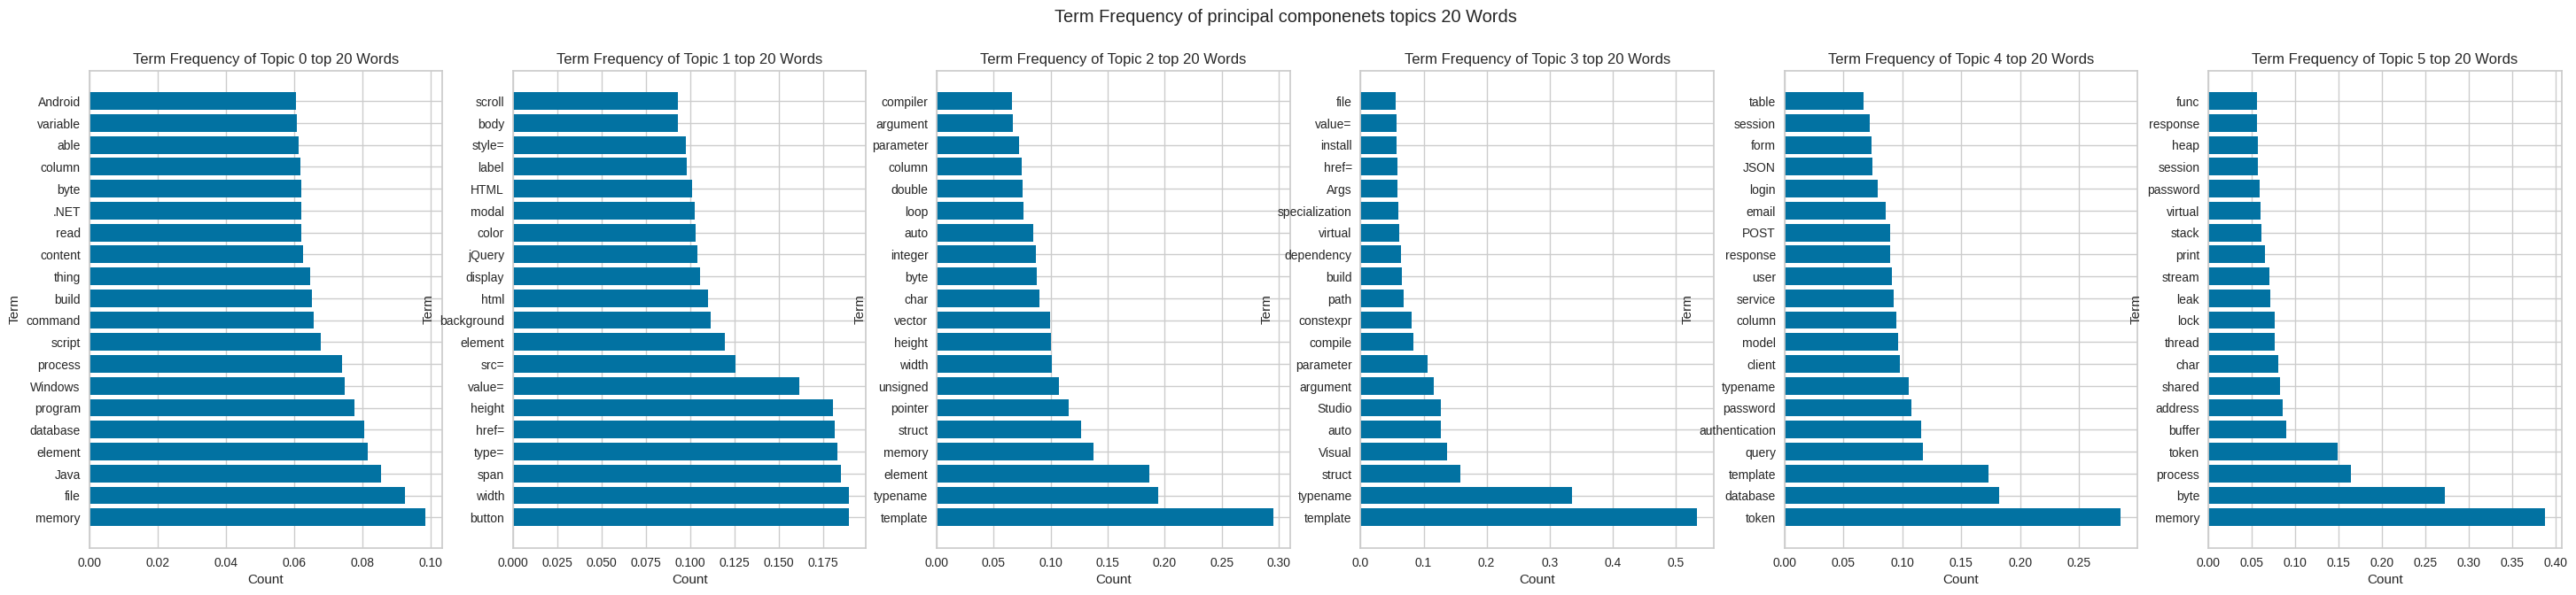

In [31]:
def plot_main_words_per_topics(topics_idx, topics_weight, dic):

    words = []
    feature_names = list(dic.token2id.keys())
    topics_words = [ str(feature_names[ind]) for ind in topics_idx]
    for i in range(len(topics_weight)):
        data = {
                "term" : topics_words[i],
                "term_weight" : topics_weight[i]
            }
        words.append(pd.DataFrame([data]))

    term_freq_df =  pd.concat(words)
    return term_freq_df




N = 20
term_freq_df = []
NB_TOPICS = 6
for i, component in enumerate(svd.components_[:NB_TOPICS]):
    topics_idx = component.argsort()[::-1][:N]  # Get the indices of the top 10 features
    topics_weight = np.sort(component)[::-1][:N]
    term_freq_df.append(plot_main_words_per_topics(topics_idx, topics_weight, id2word))

fig , axs = plt.subplots(1,NB_TOPICS,figsize=(6*NB_TOPICS,7))
for k in range(NB_TOPICS) :
    df = term_freq_df[k]
    # axs[k].clf()
    axs[k].barh(
        df['term'],
        df['term_weight']
    )
    axs[k].set_xlabel("Count")
    axs[k].set_ylabel("Term")
    axs[k].set_title(f"Term Frequency of Topic {k} top {N} Words")
fig.suptitle(f"Term Frequency of principal componenets topics {N} Words")
plt.show()



Interpretation :
- PC1 : javascript
- PC2 : html
- PC3 :
- PC4
- PC5 : authentification , server
- PC6 : C

In [155]:
print("Topics to model")
NB_TOPICS_FOR_EVALUATION = 30
NB_WORDS_PER_TOPICS = 20
Topics_LSA = []
for i, component in enumerate(svd.components_[:NB_TOPICS_FOR_EVALUATION]):
    print("Component", i + 1)
    indices = component.argsort()[::-1][:NB_WORDS_PER_TOPICS]  # Get the indices of the top 10 features
    feature_names = list(id2word.token2id.keys())
    top_features = [ str(feature_names[ind]) for ind in indices]
    Topics_LSA.append(top_features)
    print(top_features)

Topics_LSA = np.array(Topics_LSA)

Topics to model
Component 1
['memory', 'file', 'Java', 'element', 'database', 'program', 'Windows', 'process', 'script', 'command', 'build', 'thing', 'content', 'read', '.NET', 'byte', 'column', 'able', 'variable', 'Android']
Component 2
['button', 'width', 'span', 'type=', 'href=', 'height', 'value=', 'src=', 'element', 'background', 'html', 'display', 'jQuery', 'color', 'modal', 'HTML', 'label', 'style=', 'body', 'scroll']
Component 3
['template', 'typename', 'element', 'memory', 'struct', 'pointer', 'unsigned', 'width', 'height', 'vector', 'char', 'byte', 'integer', 'auto', 'loop', 'double', 'column', 'parameter', 'argument', 'compiler']
Component 4
['template', 'typename', 'struct', 'Visual', 'auto', 'Studio', 'argument', 'parameter', 'compile', 'constexpr', 'path', 'build', 'dependency', 'virtual', 'specialization', 'Args', 'href=', 'install', 'value=', 'file']
Component 5
['token', 'database', 'template', 'query', 'authentication', 'password', 'typename', 'client', 'model', 'colu

## Coherence score :
The idea is to compare topic outputs of different algorithm. To do so we must evaluate what topics are, to do so we need understand them. But actually how can we measure topic interpretability ? For a topic to be interpretable we need most important token in the topic to be coherent with each other. As we cannot process all outputs we can find mathematical measure to do that for us : Topic Coherence Metrics.

Works in four  stages :
- S segmentation  : subsets of paris of most important words from each topics
- P probability calculation : taking documents occurence within the copus, text or within sentences
- W confirmation measure : calculate P over each pair S and weighting them
- Aggregation : taking all W to output the score

Here we choose **c_v** and **u_mass** as different coherence measurements.


In [160]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(topics=Topics_LSA, corpus=tfidf_corpus, dictionary=id2word, coherence='u_mass')
u_mass_lsa = coherence_model.get_coherence()
print(u_mass_lsa)

-7.234622637541396


In [159]:
# topic_cor = Topics.apply(lambda x : id2word.doc2bow(x))

coherence_model = CoherenceModel(topics=Topics_LSA, texts=s_corpus, dictionary=id2word, coherence='c_v')
c_v_lsa = coherence_model.get_coherence()
print(c_v_lsa)

0.34994956047171805


## LDA :


The number of lines corresponds to the number of documents and the number of element in each line to the number of words token appreaing in the document. Each words is represented by an ID.

LdaMulticore is a faster implementation of LDA for parallelized computation in multicore machine.

We will tune following parameters :
- k : number of subjects
- alpha : the Ditrichlet concentration of subject by document
- beta : the Ditrichlet concentration of words per subjects

For selection we will use topic **coherence measure**, meaning the degree of semantic similarity.

Several measures exist, here we use **C_v** which is based on sliding window and based on NPMI ( Normalized Pointwise Mutual Information ).


In [52]:
# supporting function
number_of_cpu_core = 1 # 4
def compute_coherence_values(corpus, dictionary, k, alpha, beta):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           workers=number_of_cpu_core,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           eta=beta)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [79]:
alpha = list(np.round(np.arange(0.01, 1, 0.3),3))
alpha.append('symmetric')
alpha.append('asymmetric')
beta = list(np.round(np.arange(0.01, 1, 0.3),3))
beta.append('symmetric')

print("Grid search hyperparameters tunning : ")
print(alpha)
print(beta)


Grid search hyperparameters tunning : 
[0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']
[0.01, 0.31, 0.61, 0.91, 'symmetric']


In [67]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

NB_TOPICS = 30
num_of_docs = len(corpus)

model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
  pbar = tqdm.tqdm(total=(len(beta)*len(alpha)))
  for a in alpha:
      for b in beta:
          # get the coherence score for the given parameters
          lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=NB_TOPICS,
                                workers=number_of_cpu_core,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                alpha=a,
                                eta=b)

          coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='c_v')
          cv = coherence_model_lda.get_coherence()
          # Save the model results
          model_results['Alpha'].append(a)
          model_results['Beta'].append(b)
          model_results['Coherence'].append(cv)
          pbar.update(1)
  pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
  pbar.close()

 20%|██        | 6/30 [11:57<48:41, 121.73s/it]

KeyboardInterrupt: ignored

In [68]:
model_results

{'Topics': [10, 10, 10, 10, 10, 10],
 'Alpha': [0.01, 0.01, 0.01, 0.01, 0.01, 0.31],
 'Beta': [0.01, 0.31, 0.61, 0.9099999999999999, 'symmetric', 0.01],
 'Coherence': [0.42401088451995567,
  0.4063992120061256,
  0.4735457999995536,
  0.4636065926153634,
  0.47571484571207556,
  0.42414370486078146]}

In [ ]:
results_lda = pd.csv_read('./lda_tuning_results.csv', index=False)

In [86]:
df_model_results = pd.DataFrame(model_results)
df_model_results

,Topics,Alpha,Beta,Coherence
0,10,0.01,0.01,0.424011
1,10,0.01,0.31,0.406399
2,10,0.01,0.61,0.473546
3,10,0.01,0.91,0.463607
4,10,0.01,symmetric,0.475715
5,10,0.31,0.01,0.424144


In [90]:
max_config = df_model_results.query('Coherence == Coherence.max()')
max_config

,Topics,Alpha,Beta,Coherence
4,10,0.01,symmetric,0.475715


In [98]:
lda_model_tunned = gensim.models.LdaMulticore(corpus=corpus,
                      id2word=id2word,
                      num_topics=NB_TOPICS,
                      workers=number_of_cpu_core,
                      random_state=100,
                      chunksize=100,
                      passes=10,
                      alpha=max_config['Alpha'].values[0],
                      eta=max_config['Beta'].values[0])


In [147]:
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.2
    Uninstalling pandas-2.0.2:
      Successfully uninstalled pandas-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.23.2 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [148]:
import pyLDAvis
pyLDAvis.enable_notebook()


LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tunned, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.345533  0.174086       1        1  15.583615
16    -0.338575  0.130786       2        1  13.970992
15    -0.267507 -0.101688       3        1   9.400058
1     -0.300200  0.051014       4        1   9.294634
26    -0.247885 -0.041366       5        1   9.270486
7     -0.141748 -0.244795       6        1   6.611508
13    -0.083515 -0.173243       7        1   4.676009
5      0.012478 -0.041547       8        1   2.801216
25     0.001404 -0.054397       9        1   2.687472
27    -0.000240  0.042161      10        1   2.610887
22    -0.003413 -0.087600      11        1   2.522052
2      0.054826 -0.002432      12        1   2.127755
19     0.058289  0.030365      13        1   1.929917
17     0.029149 -0.011795      14        1   1.908017
28     0.083565  0.002884      15        1   1.568253
6      0.062940  0.038206      16        1   1.508473
0      0.091192  0.022621      17        1   1.346335
24     0.092915  0.032637      18        1   1.333936
9      0.076032  0.009040      19        1   1.314476
20     0.094398  0.036279      20        1   0.908612
29     0.107954  0.019946      21        1   0.837517
3      0.099157  0.022187      22        1   0.804891
11     0.107722  0.021833      23        1   0.776547
23     0.105811  0.022151      24        1   0.715732
4      0.102752  0.015366      25        1   0.669231
18     0.102559  0.003077      26        1   0.668254
8      0.107630  0.022502      27        1   0.658710
14     0.109832  0.023168      28        1   0.581269
21     0.110194  0.022042      29        1   0.551292
10     0.117818  0.016511      30        1   0.361853, topic_info=                          Term        Freq       Total Category  logprob  \
1459                      item  501.000000  501.000000  Default  30.0000   
1396                    module  553.000000  553.000000  Default  29.0000   
329                     SELECT  444.000000  444.000000  Default  28.0000   
312                       FROM  422.000000  422.000000  Default  27.0000   
696                    comment  949.000000  949.000000  Default  26.0000   
...                        ...         ...         ...      ...      ...   
8009  org.apache.spark.rdd.RDD    1.368102    2.373221  Topic30  -6.4921   
6564               data.length    1.093827    2.098946  Topic30  -6.7158   
8236                   indexer    0.904769    1.909888  Topic30  -6.9056   
1220                impression    1.585661    7.718435  Topic30  -6.3445   
1727                    Source    1.889204   95.812079  Topic30  -6.1694   

      loglift  
1459  30.0000  
1396  29.0000  
329   28.0000  
312   27.0000  
696   26.0000  
...       ...  
8009   5.0709  
6564   4.9699  
8236   4.8746  
1220   4.0391  
1727   1.6955  

[1323 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1309     14  0.955874      'data
3837     27  0.828904   'default
5196     17  0.955054     'error
8333     22  0.940111   .Include
1144      3  0.994073       .NET
...     ...       ...        ...
1208      2  0.237522       year
1208      3  0.374554       year
1208     10  0.383689       year
5849     29  0.806459  yesterday
1755      3  0.991307       zero

[1933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 17, 16, 2, 27, 8, 14, 6, 26, 28, 23, 3, 20, 18, 29, 7, 1, 25, 10, 21, 30, 4, 12, 24, 5, 19, 9, 15, 22, 11])

In [152]:
c_v_LDA = max_config['Coherence'].values[0]
c_v_LDA

0.47571484571207556

In [153]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=s_corpus, dictionary=id2word, coherence='u_mass')
u_mass_lda = coherence_model_lda.get_coherence()
u_mass_lda

-7.8719504952624755

# Word emedding and LDA : lda2vec

# K-means

Here we convert our text data into word embeeding to represent words in smaller dimension. I was train so words that can be replace in a sentence by each other are close to each others.

In [117]:

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']


#Sentences are encoded by calling model.encode()
embedding = model.encode(s_corpus)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

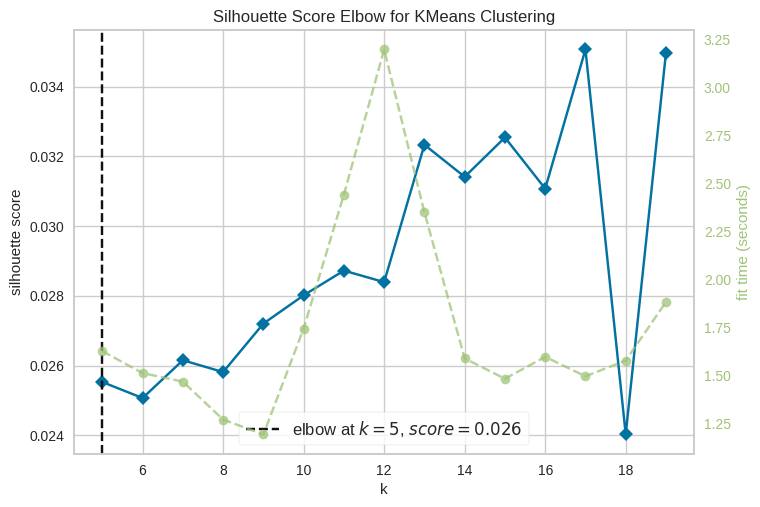

In [122]:



model = KMeans()

visualizer = KElbowVisualizer(model, k=(5, 20), metric='silhouette',n_init='auto',init='k-means++')
visualizer.fit(embedding)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

In [138]:
NB_CLUSTER = 17
km = KMeans(n_clusters=NB_CLUSTER, random_state=33,n_init='auto', init='k-means++')
km.fit(embedding)


KMeans(n_clusters=17, n_init='auto', random_state=33)

In [124]:
labels = km.labels_.tolist()

In [126]:
frame = pd.DataFrame({'words': s_corpus,'text_encoded': corpus, 'cluster' : labels}, index = labels)

In [127]:
frame[frame['cluster'] == 0 ].head()

,words,text_encoded,cluster
0,"[Convert, HTML, Text, looking, convert, HTML, ...","[(24, 1), (69, 1), (79, 1), (118, 1), (156, 1)...",0
0,"[Populate, WinForms, TreeView, DataTable, WinF...","[(19, 2), (21, 1), (39, 1), (62, 1), (75, 1), ...",0
0,"[CMake, converting, build, system, cmake, syst...","[(203, 1), (433, 1), (597, 1), (714, 1), (836,...",0
0,"[EDIT, file, React, UPDATE, lied, lack, knowle...","[(21, 2), (25, 1), (30, 2), (61, 1), (62, 1), ...",0
0,"[parse, flat, tree, Assume, flat, store, order...","[(19, 1), (24, 1), (53, 1), (181, 1), (260, 1)...",0


In [132]:
kmeas_topics = []
for i in range(17) :
  topic = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).index
  kmeas_topics.append(topic)

In [133]:
kmeas_topics

[Index(['failed', 'open', 'convert', 'node', 'foreach', 'Invalid', 'supplied',
        'argument', 'Warning', 'Notice', 'index', 'Role.php', 'Soccer',
        'Undefined', 'button', 'format', 'print', 'file', 'byte', 'channel'],
       dtype='object'),
 Index(['Google', 'certificate', '.NET', 'password', 'Windows', 'model',
        'Visual', 'ASP.NET', 'client', 'script', 'token', 'database', 'Studio',
        'Core', 'build', 'connection', 'information', 'email', 'able',
        'framework'],
       dtype='object'),
 Index(['comment', 'user', 'SELECT', 'WHERE', 'FROM', 'parent_comment_id',
        'active_model_serializers', 'Load', 'Comment', 'LIMIT', 'CACHE',
        '0.0ms', 'template', 'parameter', 'variable', 'print', 'argument',
        'pointer', 'DWORD', 'value'],
       dtype='object'),
 Index(['file', 'Windows', 'Time', 'load', 'File', 'install', 'work', 'start',
        'memory', 'command', 'href=', 'value=', 'database', 'button',
        'emulator', 'build', 'script', 'And

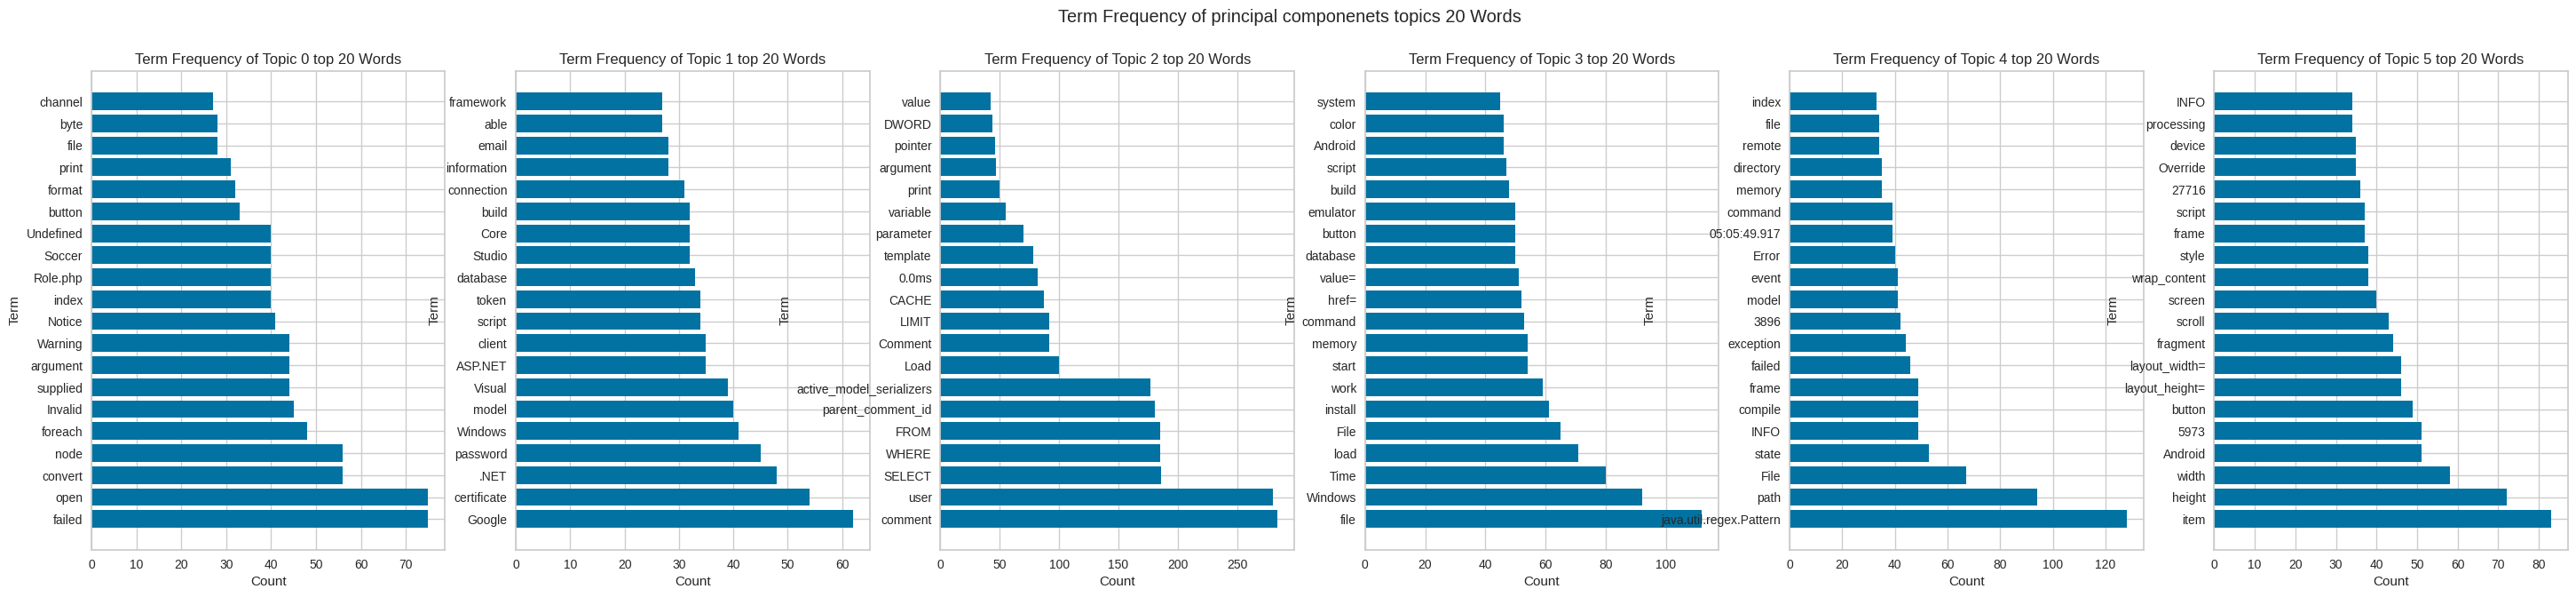

In [139]:
def k_means_topic_df(topics_words, topics_weight, dic):

    words = []
    for i in range(len(topics_weight)):
        data = {
                "term" : topics_words[i],
                "term_weight" : topics_weight[i]
            }
        words.append(pd.DataFrame([data]))

    term_freq_df =  pd.concat(words)
    return term_freq_df

NB_TOPICS = 6
kmeas_topics = []
term_freq_df = []
for i in range(NB_CLUSTER) :
  topic_words = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).index
  topic_count = frame[frame['cluster'] == i ]['words'].explode().value_counts().head(20).values
  kmeas_topics.append(topic)
  words = []
  for i in range(len(topics_weight)):
    data = {
            "term" : topic_words[i],
            "term_weight" : topic_count[i]
        }
    words.append(pd.DataFrame([data]))
  term_freq_df.append( pd.concat(words))

fig , axs = plt.subplots(1,NB_TOPICS,figsize=(6*NB_TOPICS,7))
for k in range(NB_TOPICS) :
    df = term_freq_df[k]
    # axs[k].clf()
    axs[k].barh(
        df['term'],
        df['term_weight']
    )
    axs[k].set_xlabel("Count")
    axs[k].set_ylabel("Term")
    axs[k].set_title(f"Term Frequency of Topic {k} top {N} Words")
fig.suptitle(f"Term Frequency of principal componenets topics {N} Words")
plt.show()


In [144]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_u_mass = CoherenceModel(topics=kmeas_topics, corpus=corpus, dictionary=id2word, coherence='u_mass')
u_mass_kmeans = coherence_model_u_mass.get_coherence()
print(u_mass_kmeans)

-12.306074658037259


In [163]:
# topic_cor = Topics.apply(lambda x : id2word.doc2bow(x))

coherence_model_c_v = CoherenceModel(topics=kmeas_topics, texts=s_corpus, dictionary=id2word, coherence='c_v')
c_v_kmeans = coherence_model_c_v.get_coherence()
print(c_v_kmeans)

0.4857539614223436


# Unsupervised learning model selection

In [168]:
u_mass_scores = [u_mass_lsa, u_mass_lda, u_mass_kmeans]
c_v_scores = [c_v_lsa, c_v_LDA, c_v_kmeans]
result_cohenrence_scores = pd.DataFrame(
    {
        'u_mass_scores' : u_mass_scores,
        'c_v_scores' : c_v_scores
    }, index = ['lsa','lda','kmeans']
)


In [169]:
result_cohenrence_scores

,u_mass_scores,c_v_scores
lsa,-7.234623,0.349950
lda,-7.871950,0.475715
kmeans,-12.306075,0.485754


The unsupervised model selected is **LDA**.